# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=15eGnAbma5Q_j9CZZKi46Gh3-EpgSWYOV"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Classifying disease using Deep Learning 
  </td></tr>
</table>


![alt text](https://drive.google.com/uc?id=19BuQ5m0xZWC7vQN4jX9lukmJ4aE0EkL8)

![alt text](https://drive.google.com/uc?id=10tbeSkGZ0xdHtqTGhYwHhb9PPURw0BfD)

# TASK #2: IMPORT LIBRARIES AND DATASET

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:
# Specify training data directory
XRay_Directory = '../input/pneumonia-covid-19-xray-dataset/Xray images dataset/Dataset'

In [4]:
# List the folders in the directory
os.listdir(XRay_Directory)

['2', '3', '0', '1']

In [5]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [6]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size=40,directory=XRay_Directory,target_size=(256,256),shuffle=True,class_mode='categorical',subset='training')
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing


Found 428 images belonging to 4 classes.


In [7]:
validation_generator = image_generator.flow_from_directory(batch_size=40,directory=XRay_Directory,target_size=(256,256),shuffle=True,class_mode='categorical',subset='validation')

Found 104 images belonging to 4 classes.


In [8]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [9]:
train_images.shape, train_labels.shape

((40, 256, 256, 3), (40, 4))

In [10]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

# TASK #3: VISUALIZE DATASET

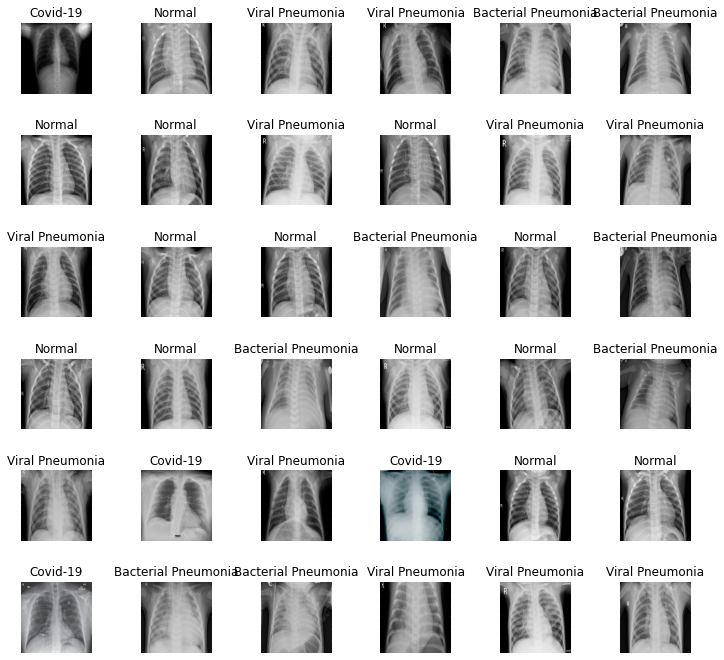

In [11]:
# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.7)   

# TASK #4: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS

![alt text](https://drive.google.com/uc?id=176TJGdJtNZmX4J5QyeI8W_YS5f1gg5VS)

![alt text](https://drive.google.com/uc?id=1340UvqbXc-sy6cIuVg7ZbOwcga2JxfkP)

![alt text](https://drive.google.com/uc?id=1hngDlUf9JnwUhPII-Ah7KTtcvoeTI9m8)

![alt text](https://drive.google.com/uc?id=1nt8iX7H2LEhaWgGCi_NIb05DMQEoJVfI)

# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND TRANSFER LEARNING

![alt text](https://drive.google.com/uc?id=1Wnti2DSmA2qMRsgkD7Z_MJkmed0bJZTN)

![alt text](https://drive.google.com/uc?id=1Chdq0gdnHGYDDb50pMMtcTOZMr0u37Iz)

![alt text](https://drive.google.com/uc?id=14niGb232X6l8OD1dMT4a_u3fjh_jKuMS)

![alt text](https://drive.google.com/uc?id=1dye4zWALCDu8a1a-58HfZk4On4nVuizV)

# TASK #6: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [12]:
basemodel = ResNet50(weights = 'imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 1s 0us/step


In [13]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [14]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
  layers.trainable = False

# TASK #7: BUILD AND TRAIN DEEP LEARNING MODEL

In [43]:
# taking output from our trained basemodel and building our classification model over it.
headmodel = basemodel.output 
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(64, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [44]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

In [45]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [46]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [47]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 16, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/16
107/107 [==============================] - ETA: 0s - loss: 1.4419 - accuracy: 0.4556
Epoch 00001: val_loss improved from inf to 0.51802, saving model to weights.hdf5
107/107 [==============================] - 23s 217ms/step - loss: 1.4419 - accuracy: 0.4556 - val_loss: 0.5180 - val_accuracy: 0.8269
Epoch 2/16
107/107 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.6379 ETA: 0s - loss: 0.9611 - accuracy
Epoch 00002: val_loss did not improve from 0.51802
107/107 [==============================] - 22s 206ms/step - loss: 0.9607 - accuracy: 0.6379 - val_loss: 0.8054 - val_accuracy: 0.7788
Epoch 3/16
107/107 [==============================] - ETA: 0s - loss: 0.8065 - accuracy: 0.7079
Epoch 00003: val_loss improved from 0.51802 to 0.31776, saving model to weights.hdf5
107/107 [==============================] - 22s 206ms/step - loss: 0.8065 - accuracy: 0.7079 - val_loss: 0.3178 - val_accuracy: 0.9135
Epoch 4/16
107/107 [==============================] - ETA: 

# TASK #8: EVALUATE TRAINED DEEP LEARNING MODEL

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

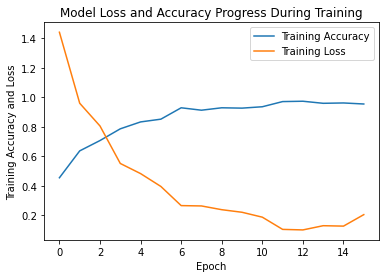

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

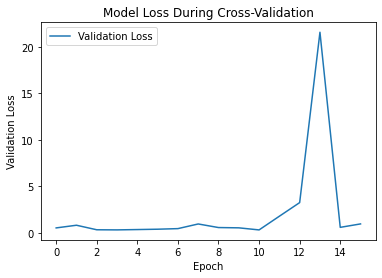

In [50]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

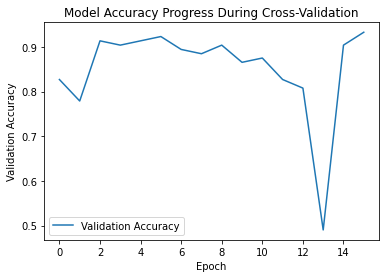

In [51]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [52]:
test_directory = '../input/pneumonia-covid-19-xray-dataset/Xray images dataset/Test'

In [53]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
 1/10 [==>...........................] - 0s 9ms/step - loss: 2.4846 - accuracy: 0.7750
Accuracy Test : 0.7749999761581421


In [54]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [55]:
len(original)

40

In [56]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.775


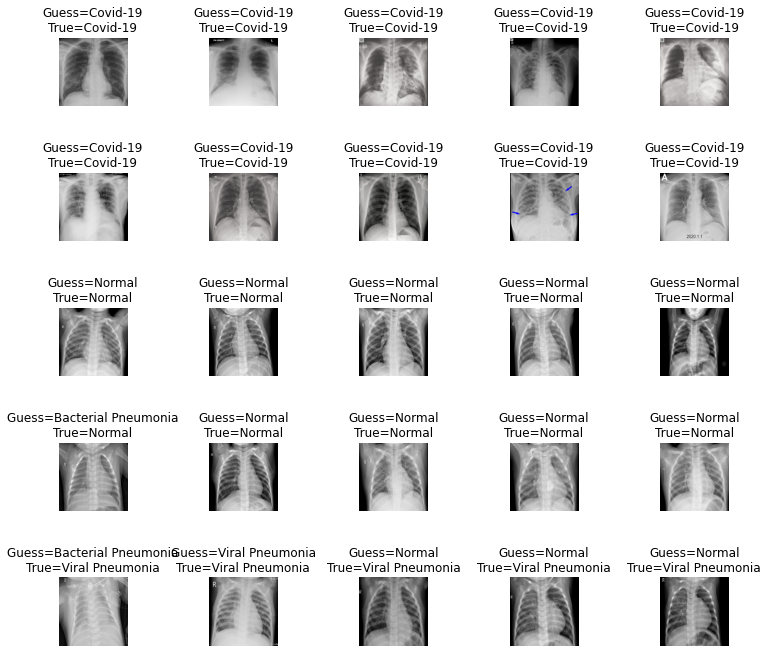

In [57]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [58]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.56      0.90      0.69        10
           2       1.00      0.40      0.57        10
           3       0.80      0.80      0.80        10

    accuracy                           0.78        40
   macro avg       0.84      0.77      0.77        40
weighted avg       0.84      0.78      0.77        40



Text(0.5, 1.0, 'Confusion_matrix')

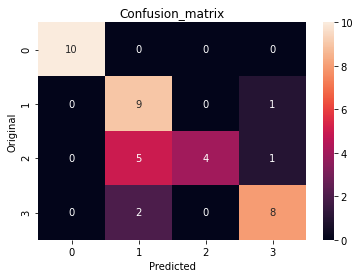

In [59]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

**As seen my model has a test_acc of around 78% which is good. But as a deep learning model classifing such important task. I would expect a test_accuracy of more than 95%. I tried playing around with the model. I would be coming back and tuning the model as I want it to be 100% accurate. While detecting Viral Pneunomina its making huge errors, that is what I would never want because in Medical predictions the recall and precision has to be very high. 
I would appreciate if someone can add something to my notebook and let me know feedback.
Anyways using ResNet50 model for transfer learning is really helpful. I would like to try it with vgg19 too in future.**